### References
- https://www.kaggle.com/code/ambrosm/amex-eda-which-makes-sense
- https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline

In [7]:
%matplotlib inline

import os
import calendar
from pathlib import Path
import numpy as np
import networkx as nx
import pandas as pd
from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns
import pickle, gc
from matplotlib import pyplot as plt
import math
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier
import matplotlib.colors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc


import warnings

## 1. The Labels

In [28]:
train_labels = pd.read_csv('D:/숙탯 2기/2022-여름-캐글/train_labels.csv')
train_labels.head(10)

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0
5,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,0
6,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0
7,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,0
8,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,1
9,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,1


In [27]:
train_labels.shape

(458913, 2)

In [30]:
# Check for missing data and duplicated customer_IDs
train_labels.isna().any().any(), train_labels.customer_ID.duplicated().any()

(False, False)

- 누락된 레이블 없음, 중복된 고객 ID 없음

In [14]:
label_stats = pd.DataFrame({'absolute': train_labels.target.value_counts(),
              'relative': train_labels.target.value_counts() / len(train_labels)})
label_stats['absolute upsampled'] =  label_stats.absolute * np.array([20, 1])
label_stats['relative upsampled'] = label_stats['absolute upsampled'] / label_stats['absolute upsampled'].sum()
label_stats

,absolute,relative,absolute upsampled,relative upsampled
0,340085,0.741066,6801700,0.98283
1,118828,0.258934,118828,0.01717


- 레이블이 0인 데이터가 언더샘플링되어 있는 자료이므로 실제 수치를 비교하면 위와 같음.
- Undersampling: 많은 데이터 셋을 적은 데이터 셋 수준으로 감소시키는 방식. 가령 정상 레이블을 가진 데이터가 10,000건, 비정상 레이블을 가진 데이터가 100건이 있을 경우 정상 레이블 데이터를 100건으로 줄이는 방식이다.

#### 불균형한 자료임
- 따라서 StratifiedKFold 기법으로 교차검증하는 것이 좋을 것으로 판단됨
- 성능 평가 metric으로 accuracy는 적합하지 않고, ROC curve와 AUC(Area Under the ROC Curve)가 적합함.

## 2. The Data

In [16]:
conda install -c conda-forge pyarrow

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\judyj\anaconda3

  added / updated specs:
    - pyarrow


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aom-3.3.0                  |       h0e60522_1        11.2 MB  conda-forge
    arrow-cpp-8.0.0            |   py39hbd6f097_0         6.2 MB
    aws-c-common-0.4.57        |       ha925a31_1         147 KB
    aws-c-event-stream-0.1.6   |       hd77b12b_5          26 KB
    aws-checksums-0.1.9        |       ha925a31_0          50 KB
    aws-sdk-cpp-1.8.185        |       hd77b12b_0         2.5 MB
    blosc-1.21.1               |       h74325e0_3          49 KB  conda-forge
    boost-cpp-1.79.0           |       h9f4b32c_0        17.2 MB  conda-forge
    c-ares-1.18.1              |       h8ffe710_0         114 KB  conda-forge
    c-blosc2-2.2.0             |       hdf67494_0         173 KB  c



==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base -c defaults conda




    openssl-1.1.1q             |       h8ffe710_0         5.8 MB  conda-forge
    pyarrow-8.0.0              |   py39h953b917_0         2.1 MB
    re2-2022.04.01             |       h0e60522_0         472 KB  conda-forge
    snappy-1.1.9               |       h82413e6_1          55 KB  conda-forge
    utf8proc-2.6.1             |       h2bbff1b_0         312 KB
    zlib-1.2.12                |       h8ffe710_2         112 KB  conda-forge
    zlib-ng-2.0.6              |       h8ffe710_0          93 KB  conda-forge
    zstd-1.5.2                 |       h6255e5f_2         987 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        62.2 MB

The following NEW packages will be INSTALLED:

  aom                conda-forge/win-64::aom-3.3.0-h0e60522_1
  arrow-cpp          pkgs/main/win-64::arrow-cpp-8.0.0-py39hbd6f097_0
  aws-c-common       pkgs/main/win-64::aws-c-common-0.4.57-ha925a31_1
  aws-c-event-stream p

In [17]:
train = pd.read_feather('D:/숙탯 2기/2022-여름-캐글/train_data.ftr')
test = pd.read_feather('D:/숙탯 2기/2022-여름-캐글/test_data.ftr')
with pd.option_context("display.min_rows", 6):
    display(train)
    display(test)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,...,NaN,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983,0
5531450,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-03-14,0.981934,0.002474,0.000077,0.992676,0.000809,0.119141,0.003286,0.014091,...,NaN,NaN,0.007317,0.002888,0.006207,NaN,0.005112,0.003183,0.001914,0


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.608887,0.003326,0.016388,1.004883,0.000114,0.267090,0.004196,0.004192,...,NaN,NaN,NaN,0.000074,0.002113,0.004658,NaN,0.003155,0.002155,0.006481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363759,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-02-17,0.459961,0.005245,0.004421,0.818848,0.000665,NaN,0.000559,0.007057,...,NaN,NaN,NaN,0.007797,0.007740,0.008194,NaN,0.009384,0.003593,0.005604
11363760,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-03-19,0.460449,0.002663,0.009529,0.816406,0.009026,NaN,0.008530,0.006851,...,NaN,NaN,NaN,0.007195,0.008453,0.004776,NaN,0.006199,0.005604,0.005970
11363761,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-04-18,0.454590,0.004402,0.000346,0.810059,0.008736,NaN,0.000937,0.003494,...,NaN,NaN,NaN,0.003399,0.009590,0.006187,NaN,0.007675,0.006443,0.003143


cf) The target column of the train dataframe corresponds to the target column of train_labels.csv. In the csv file of the train data, there is no target column; it has been joined into the Feather file as a convenience.

In [18]:
print('Train statement dates: ', train.S_2.min(), train.S_2.max(), train.S_2.isna().any())
print('Test statement dates: ',  test.S_2.min(), test.S_2.max(), test.S_2.isna().any())

Train statement dates:  2017-03-01 00:00:00 2018-03-31 00:00:00 False
Test statement dates:  2018-04-01 00:00:00 2019-10-31 00:00:00 False


- S_2: statement date
- train statement dates와 test statement dates 간에 겹치는 기간 없고, 결측치도 없음

#### Economic cycle:
- The test data come from a different phase in the economic cycle than the training data. Our models have no way of learning the effect of the economic cycle. (경제적 사이클의 효과를 학습하는 방법은 없음)

In [25]:
print(f'Train data memory usage: {train.memory_usage().sum() / 1e9} GBytes')
print(f'Test data memory usage:  {test.memory_usage().sum() / 1e9} GBytes')

Train data memory usage: 2.151736827 GBytes
Test data memory usage:  4.329595558 GBytes


- 데이터 크기가 커서 메모리 사용량이 큼. 메모리를 효율적으로 사용할 방법을 강구해야 함
- 테스트 데이터는 배치 단위로 처리
- training과 inference code를 두 개의 notebook으로 나눠서 작성해 training data와 test data가 동시에 메모리 사용하지 않게끔 하기

In [26]:
train.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float16       
 3    D_39         5531451 non-null  float16       
 4    B_1          5531451 non-null  float16       
 5    B_2          5529435 non-null  float16       
 6    R_1          5531451 non-null  float16       
 7    S_3          4510907 non-null  float16       
 8    D_41         5529435 non-null  float16       
 9    B_3          5529435 non-null  float16       
 10   D_42         791314 non-null   float16       
 11   D_43         3873055 non-null  float16       
 12   D_44         5257132 non-null  float16       
 13   B_4          5531451 non-null  float16       
 14   D_45         5529434 non-null  float16       
 1

In [34]:
train.isna().sum()

customer_ID          0
S_2                  0
P_2              45985
D_39                 0
B_1                  0
                ...   
D_142          4587043
D_143           101548
D_144            40727
D_145           101548
target               0
Length: 191, dtype: int64

- 대부분의 feature에 결측치 존재 (non-null인 데이터가 5531451개보다 적은 feature들)
- non-null count: The count() function is used to get number of non-NA/null observations in the Series

#### 결측치:
- 결측치 존재하는 열(행)이 많음. 따라서 결측치 존재하는 해당 열(행)을 모두 삭제(drop)하는 것은 적절한 방법이 아님.
- decision-tree 기반 모델들이 결측치 처리 적절히 할 수 있으므로 이러한 모델들 적용해보는 방법이 있음.
- 신경망 모델들은 결측치가 존재하는 데이터에 사용 불가하므로 결측치를 다른 값으로 impute(대체)해준 뒤 사용할 것.
- 원 자료(csv 파일)보다 ftr 파일에서 float 비트 수를 줄여서 결측치가 대거 발생했을 수 있음. 대략적인 분석 초기에는 괜찮지만, 분석 진행해갈수록 원 자료의 정확한 값을 사용할 필요가 있어보임.

### 2.1 Statements

#### Counting the statements per customer

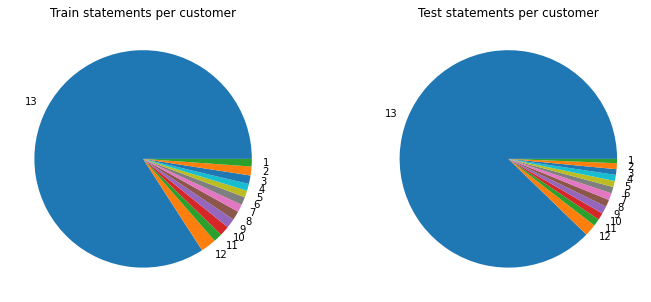

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_sc = train.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Train statements per customer')
ax1.pie(train_sc, labels=train_sc.index)
ax1.set_title(train_sc.name)
test_sc = test.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Test statements per customer')
ax2.pie(test_sc, labels=test_sc.index)
ax2.set_title(test_sc.name)
plt.show()

#### 고객들이 명세서를 받은 가장 최근 일자

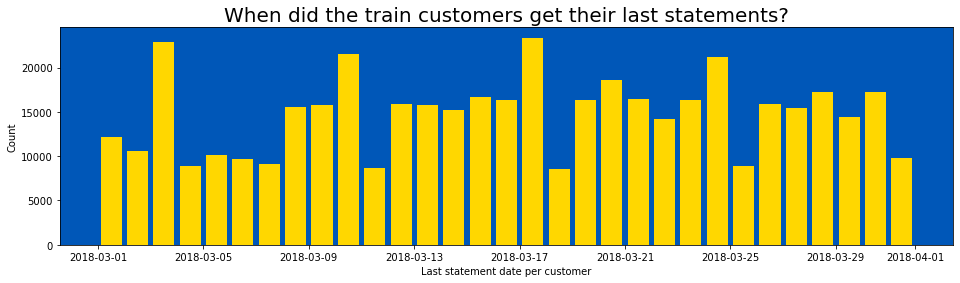

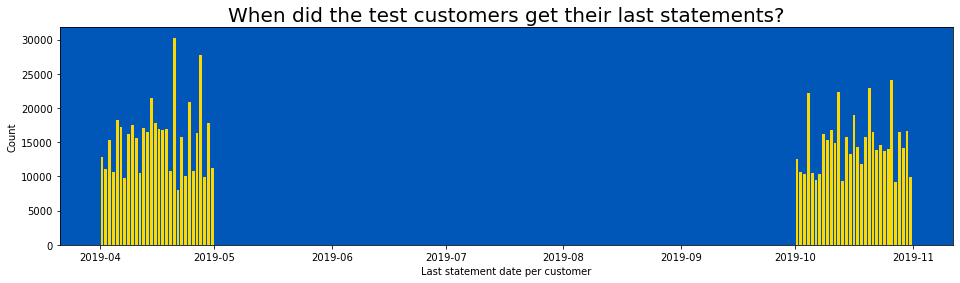

In [38]:
temp = train.S_2.groupby(train.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range("2018-03-01", "2018-04-01", freq="d"),
         rwidth=0.8, color='#ffd700')
plt.title('When did the train customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

temp = test.S_2.groupby(test.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range("2019-04-01", "2019-11-01", freq="d"),
         rwidth=0.74, color='#ffd700')
plt.title('When did the test customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

- training data의 고객들의 최근 일자는 모두 2018년 3월로 같은 달이므로 cannot cross-validate with a TimeSeriesSplit
- train data: 네 번의 토요일(March 3, 10, 17, 24)이 가장 높은 비율을 기록하였음.
- test data: 2019년 4월과 2019년 10월로 일자가 모여있음.

#### first statement와 last statement 사이의 시차

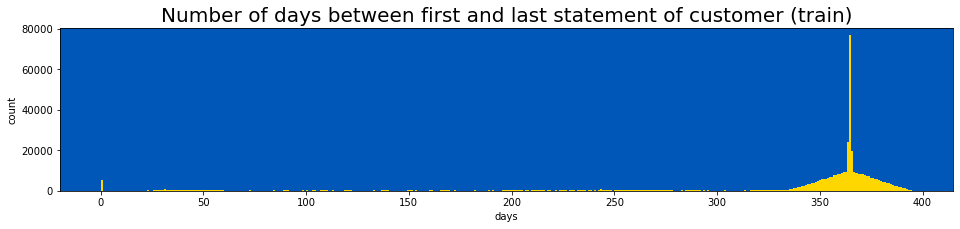

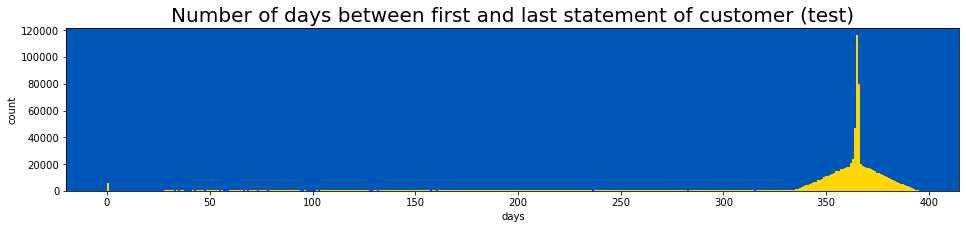

In [39]:
temp = train.S_2.groupby(train.customer_ID).agg(['max', 'min'])
plt.figure(figsize=(16, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (train)', fontsize=20)
plt.gca().set_facecolor('#0057b8')
plt.show()

temp = test.S_2.groupby(test.customer_ID).agg(['max', 'min'])
plt.figure(figsize=(16, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (test)', fontsize=20)
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

- 대부분의 고객들이 13번의 statement를 받았고, statement date 기간은 13개월이며, first statement와 last statement 사이의 시차가 약 한 달이므로 한 달에 한 번꼴로 statement를 받았다는 것을 유추할 수 있음.

### 2.2 EDA of Delinquency(연체) Variables

C:\Users\judyj\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


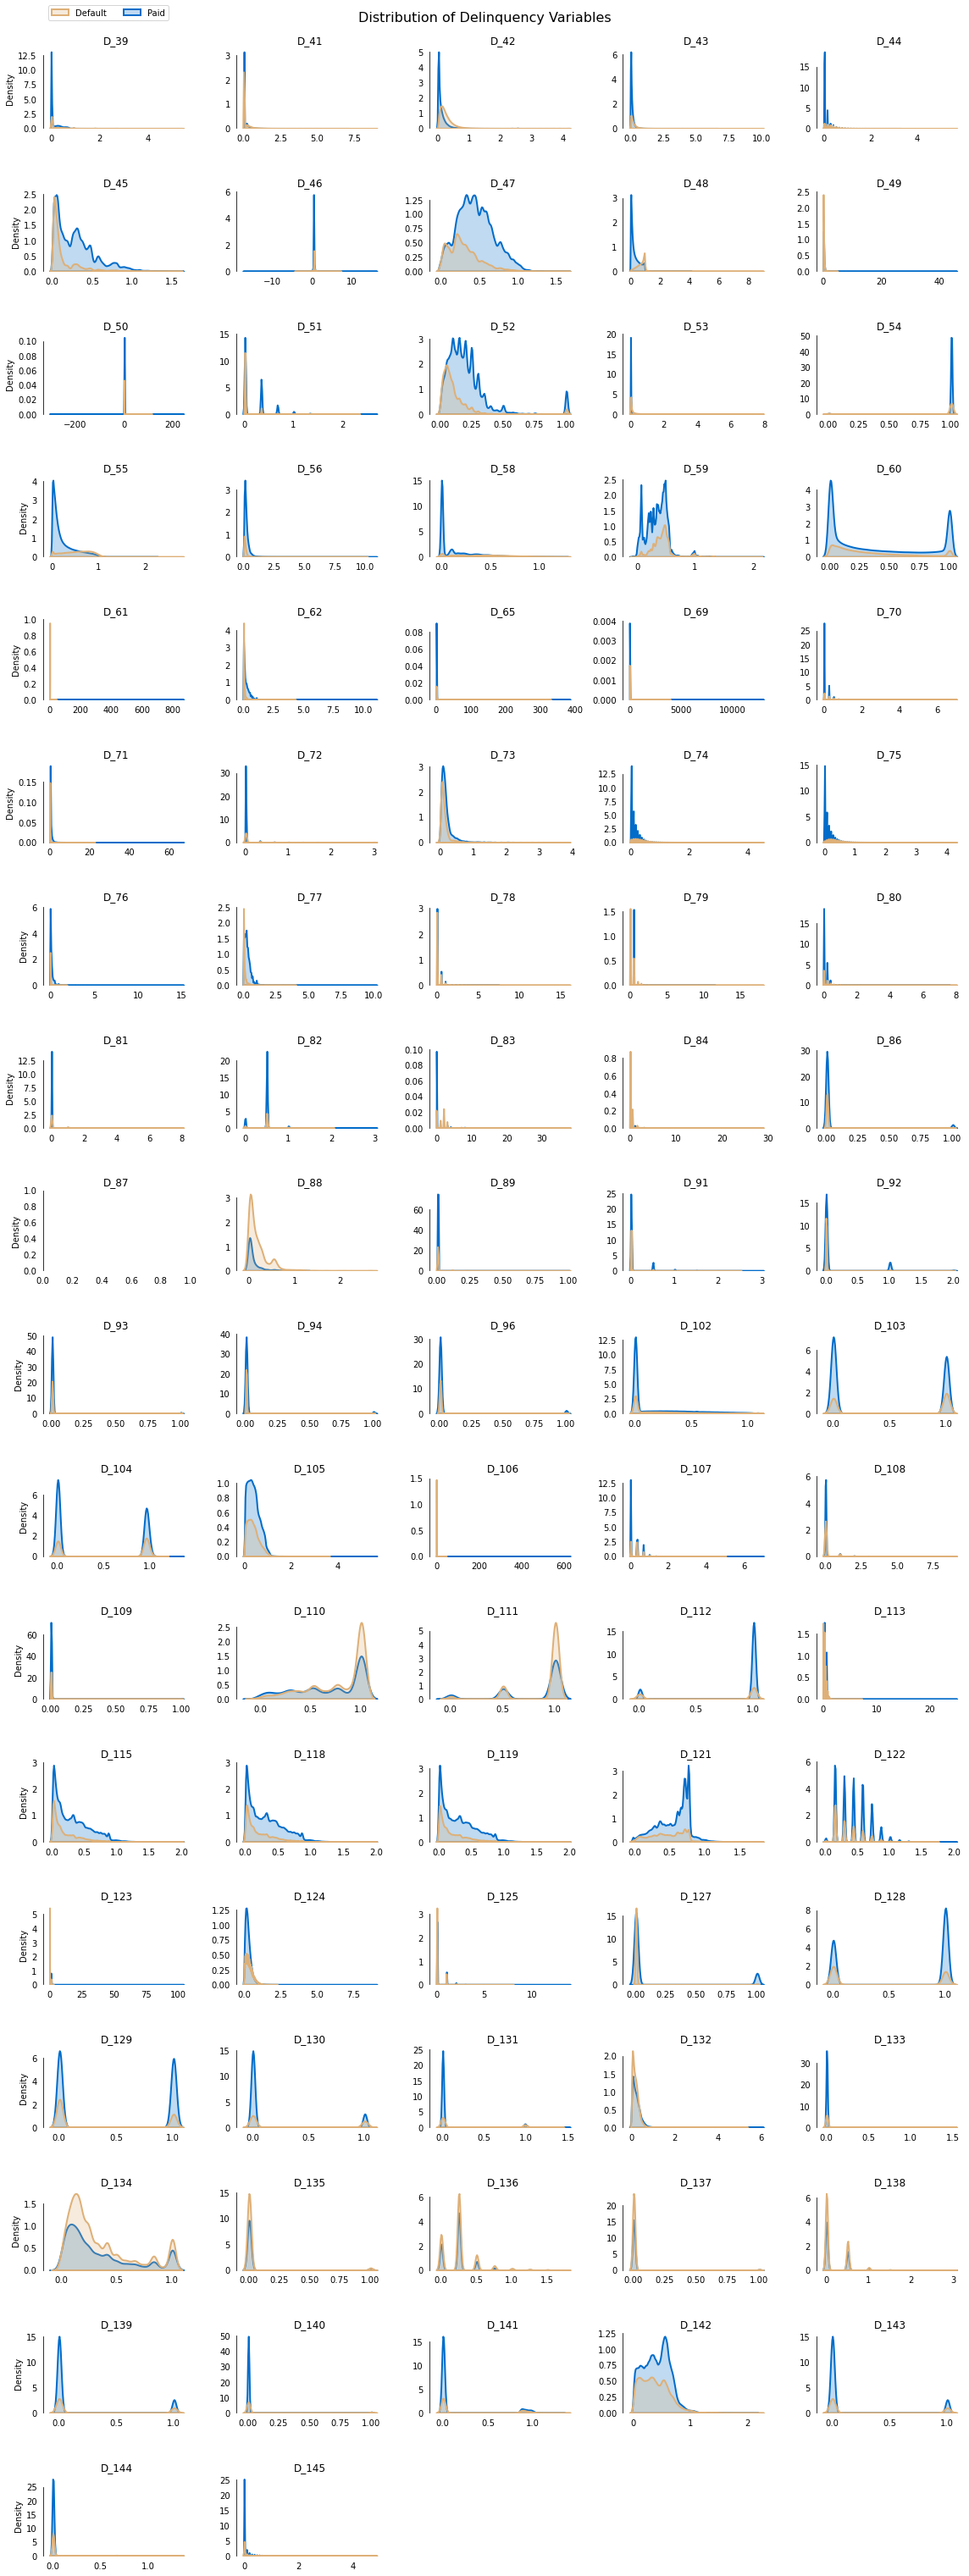

In [42]:
cat_cols=['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', 'target']   # categorical

cols=[col for col in train.columns if (col.startswith(('D','t'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(18,5, figsize=(16,54))
fig.suptitle('Distribution of Delinquency Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*18
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(2,5):
    ax[17,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.983))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

C:\Users\judyj\AppData\Local\Temp\ipykernel_13224\3454807579.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


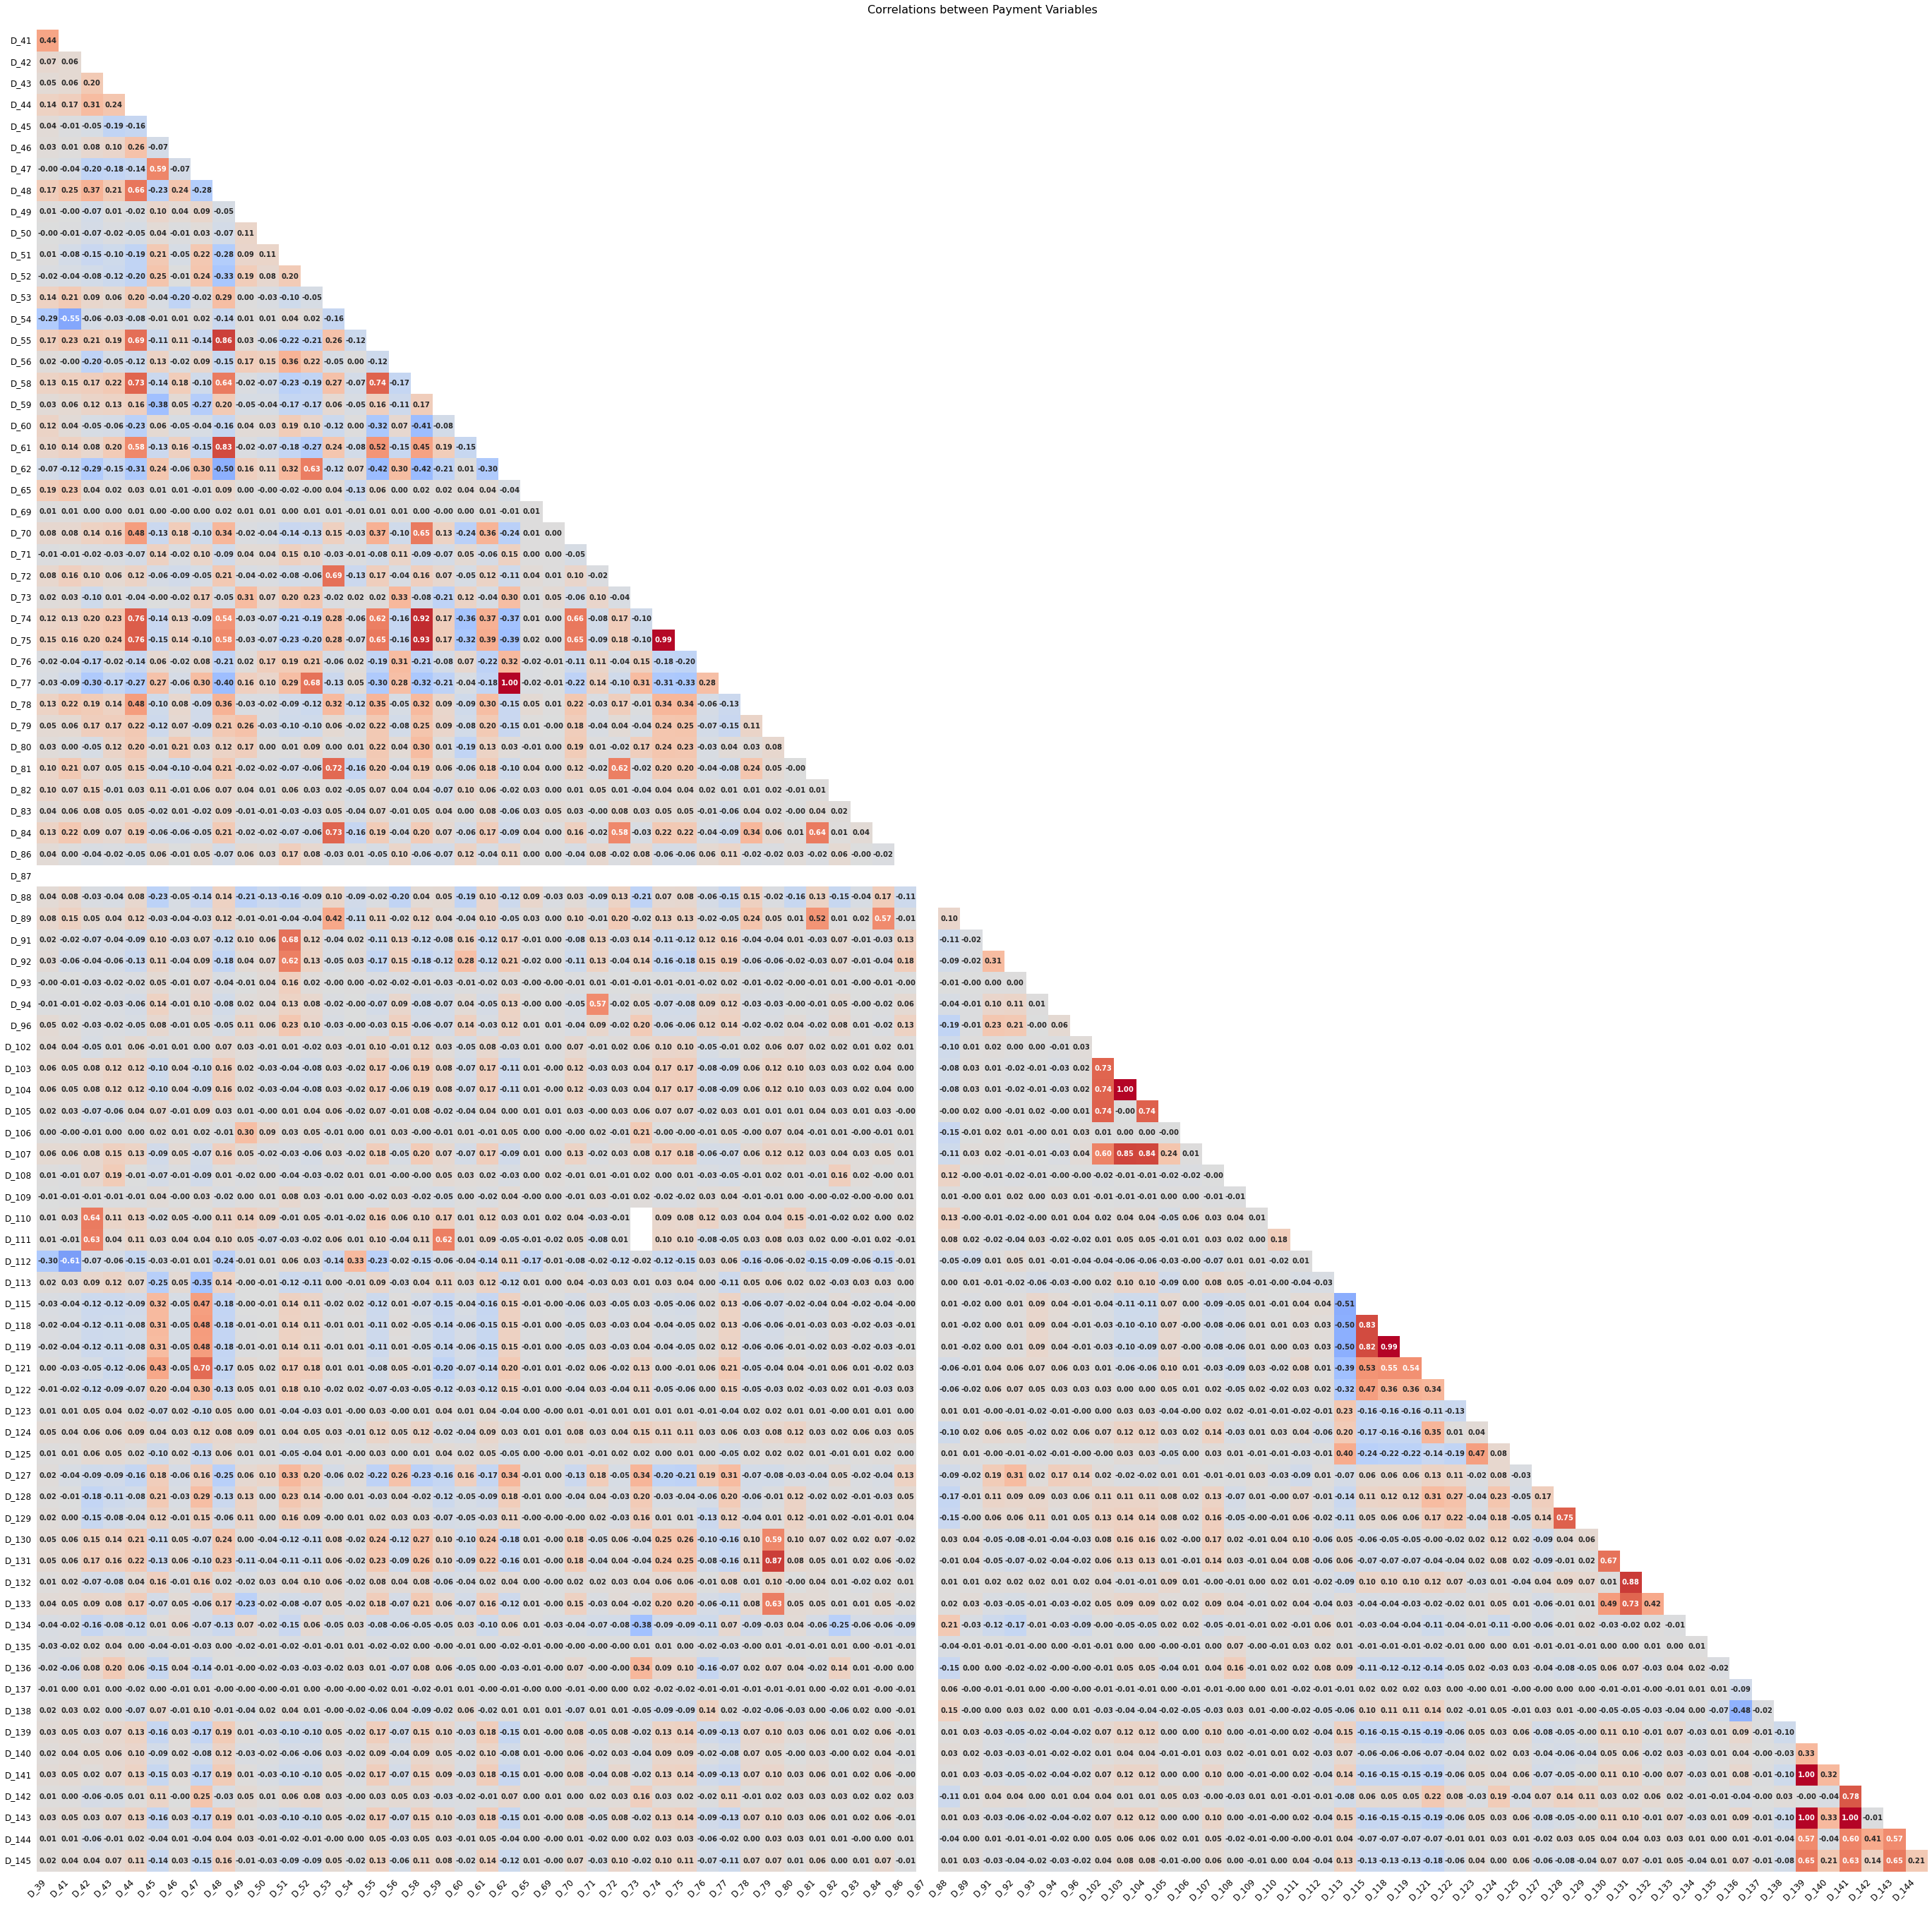

In [43]:
corr=plot_df.iloc[:,:-1].corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(48,48))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Payment Variables\n', fontsize=16)
fig.show()